# 🔹 Part 1: Normal Flow (Non-Agentic, No Tool, No Memory)
A simple LangGraph flow where the LLM answers directly based on internal knowledge.

In [1]:

import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
model = "deepseek-r1-distill-llama-70b"
llm = ChatGroq(model_name=model)

print(llm.invoke("hi").content)


<think>

</think>

Hello! How can I assist you today? 😊


### 🧠 AgentState: Message Type Comparison

| Feature                         | `AnyMessage + add_messages`                           | `BaseMessage + operator.add`                     |
|---------------------------------|--------------------------------------------------------|--------------------------------------------------|
| **Message Type**                | `AnyMessage` (supports all message types)             | `BaseMessage` (base class for Human/AI/system)   |
| **Reducer Function**            | `add_messages` (LangGraph built-in reducer)           | `operator.add` (Python standard list addition)   |
| **Flexibility**                 | ✅ High (any message structure)                       | ⚠️ Moderate (expects structured BaseMessage)     |
| **Type Safety**                 | ⚠️ Less strict (accepts mixed/untyped input)          | ✅ Strong (enforces BaseMessage types)           |
| **Best Use Case**               | Chatbots with mixed message flows                     | Custom agents where control is important         |
| **Built-in LangGraph Support**  | ✅ Yes (used in prebuilt agents like chatbots)         | ❌ No (you manage all state logic)               |
| **Ease of Use**                 | ✅ Beginner-friendly and clean                         | ⚠️ Requires manual handling of types             |
| **Supports Streaming/Memory**  | ✅ Yes                                                | ✅ Yes                                            |



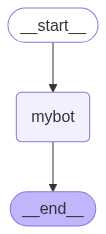

Output from mybot Node
_______
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.188077176, 'prompt_time': 0.008072412, 'queue_time': 0.223122446, 'total_time': 0.196149588}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--8300a9d5-0a60-40eb-b48f-e114b9cce270-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}




In [12]:

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#from langchain_core.messages import BaseMessage
#class AgentState(TypedDict):
#   messages: Annotated[Sequence[BaseMessage], operator.add]

def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

workflow = StateGraph(MessagesState)
workflow.add_node("mybot", call_model)
workflow.add_edge(START, "mybot")
workflow.add_edge("mybot", END)
app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

input_data = {"messages": ["hi hello how are you?"]}
app.invoke(input_data)

for output in app.stream(input_data):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")


# 🔸 Part 2: Agentic Flow with Tool Calling
The LLM decides whether to use a tool and responds based on that.

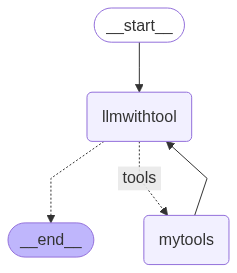

The weather in Bengaluru is currently 25 degrees with cloudy conditions. Enjoy the pleasant weather—perfect for a walk or a cup of coffee outdoors!
The weather in Delhi is currently 45 degrees and sunny.
Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?
Here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rkr5yya15', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 197, 'prompt_tokens': 134, 'total_tokens': 331, 'completion_time': 0.818128552, 'prompt_time': 0.008560846, 'queue_time': 0.220910377, 'total_time': 0.826689398}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d65f5ea3-ae86-447a-9f70-c2f4f7fea82a-0', tool_cal

In [14]:

from langchain_core.tools import tool

@tool
def search(query:str):
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

tools = [search]
llm_with_tools = llm.bind_tools(tools)

def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

workflow2 = StateGraph(MessagesState)
workflow2.add_node("llmwithtool", call_model)
workflow2.add_node("mytools", tool_node)
workflow2.add_edge(START, "llmwithtool")
workflow2.add_conditional_edges("llmwithtool", router_function, {"tools": "mytools", END: END})
workflow2.add_edge("mytools", "llmwithtool")
app2 = workflow2.compile()

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

print(app2.invoke({"messages": ["what is a weather in bengaluru?"]})["messages"][-1].content)
print(app2.invoke({"messages": ["what is a weather in delhi?"]})["messages"][-1].content)
print(app2.invoke({"messages": ["hi how are you?"]})["messages"][-1].content)

for output in app2.stream({"messages": ["what is a weather in new delhi?"]}):
    for key, value in output.items():
        print(f"Here is output from {key}")
        print("_______")
        print(value)
        print("\n")


# 🟢 Part 3: Memory Saver with Threaded Conversations
Maintains long-term conversation memory using MemorySaver.

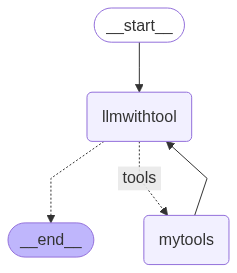

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (9bxk2a3v3)
 Call ID: 9bxk2a3v3
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny
================================== Ai Message ==================================

The weather in New Delhi is currently 45 degrees and sunny. It seems quite warm there! Let me know if you'd like more details.
================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (dyhxdbqgs)
 Call ID: dyhxdbqgs
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search


{'v': 3,
 'ts': '2025-07-03T02:09:45.508560+00:00',
 'id': '1f057b2c-a1b9-64e8-800f-6a6d7ea475bc',
 'channel_versions': {'__start__': '00000000000000000000000000000016.0.43571512253566147',
  'messages': '00000000000000000000000000000017.0.7456281634370822',
  'branch:to:llmwithtool': '00000000000000000000000000000017.0.42786481240982965',
  'branch:to:mytools': '00000000000000000000000000000013.0.8495368483633161'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000015.0.7261579770734354'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000016.0.2085877969740979'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000012.0.6731930100407827'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='be66bae8-e817-41b5-899a-6a1d383143a8'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9bxk2a3v3', 'function':

In [18]:

from langgraph.checkpoint.memory import MemorySaver

# Create new memory and attach it to the LangGraph app
memory = MemorySaver()
workflow3 = StateGraph(MessagesState)

workflow3.add_node("llmwithtool", call_model)
workflow3.add_node("mytools", tool_node)

workflow3.add_edge(START, "llmwithtool")
workflow3.add_conditional_edges("llmwithtool", router_function, {
    "tools": "mytools",
    END: END
})
workflow3.add_edge("mytools", "llmwithtool")

# Compile app with checkpointer
app4 = workflow3.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

# Thread config
config = {"configurable": {"thread_id": "1"}}

# Stream 1: New Delhi
events = app4.stream({"messages": ["what is a weather in new delhi?"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

# Stream 2: Indore
events = app4.stream({"messages": ["what is a weather in indore?"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

# Show memory contents
memory.get(config)

# Follow-up question leveraging memory
events = app4.stream({"messages": ["in which city the temp was 25 degree?"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

# Final memory dump
memory.get(config)
